In [3]:
#!/usr/bin/python

# ode simulations of the persistence model
# by DBR 3/2017 #

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyDOE
from scipy.stats import pearsonr,spearmanr

rez=600 #used for making all figures

In [4]:
#odes with the tracker    
Yc=np.zeros(14); #vector for ODE solutions 
def phaseODEtracker(Xc,t,tau,xi,bt,n,a,d,Is_0,pct_sanc,decay_s):
            
    I1  = Xc[0];                              #productively infected cells
    I2  = Xc[1];                              #preintegration cells
    I3e = Xc[2];  I3c = Xc[3]; I3n = Xc[4]; #reservoir cells of different phenotypes
    
    #tracking variables, i for infection, p for proliferation
    I1i  = Xc[5]; 
    I2i  = Xc[6];  I2p  = Xc[7];
    I3ie = Xc[8];  I3pe = Xc[9];
    I3ic = Xc[10]; I3pc = Xc[11];
    I3in = Xc[12]; I3pn = Xc[13];
    
    S=S0*np.exp(-decay_s*t);          #susceptible cells
    V=n*(I1+pct_sanc*Is_0*np.exp(-decay_s*t))  #total virus
    
    #set of odes with reservoir heterogeneity
    Yc[0] = tau[0]*bt*S*V + (a[0]-d[0]-xi[0])*I1 + sum(xi[1:]*Xc[1:5])  #I1
    Yc[1] = tau[1]*bt*S*V + (a[1]-d[1]-xi[1])*I2                    #I2
    Yc[2] = tau[2]*bt*S*V + (a[2]-d[2]-xi[2])*I3e                 #I3em
    Yc[3] = tau[3]*bt*S*V + (a[3]-d[3]-xi[3])*I3c                 #I3cm
    Yc[4] = tau[4]*bt*S*V + (a[4]-d[4]-xi[4])*I3n                  #I3n

    #equations for tracking variables 
    Yc[5] = tau[0]*bt*S*V - d[0]*I1i + xi[1]*I2i + xi[2]*I3ie + xi[3]*I3ic + xi[4]*I3in #I1 infected
    Yc[6] = tau[1]*bt*S*V - d[1]*I2i - xi[1]*I2i  #I2 infected
    Yc[8] = tau[2]*bt*S*V - (d[2] + xi[2])*I3ie  #I3em infected
    Yc[10]= tau[3]*bt*S*V - (d[3] + xi[3])*I3ic  #I3cm infected
    Yc[12]= tau[4]*bt*S*V - (d[4] + xi[4])*I3in   #I3n infected

    Yc[7] = a[1]*I2  - d[1]*I2p - xi[1]*I2p  #I2 proliferating
    Yc[9] = a[2]*I3e - (d[2]+xi[2])*I3pe     #I3em proliferating    
    Yc[11]= a[3]*I3c - (d[3]+xi[3])*I3pc     #I3cm proliferating    
    Yc[13]= a[4]*I3n - (d[4]+xi[4])*I3pn     #I3n proliferating
              
    return Yc
    
#function that evaluates the model
def evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s):
    
    Xc0 = [ I1_0,
            I2_0,
            I3_0*pie[0],
            I3_0*pie[1],
            I3_0*pie[2],
            I1_0,
            I2_0,           #I2_0 from activation
            0,              #I2_0 from proliferation
            I3_0*pie[0],
            0,
            I3_0*pie[1],
            0,
            I3_0*pie[2],
            0]
    
    dt=t[1]
    
    bt_s = bt0*(1-eps_s)                    #infectivity in the sanctuary
    Is_0 = aS/-th[0]-dS/bt_s/n            #initial size of sanctuary
    Is_t = Is_0*pct_sanc*np.exp(-decay_s*t) #inf cells in sanctuary over time  
    bt   = bt0*(1-eps)                      #infectivity outside the sanctuary
    
    x=odeint(phaseODEtracker, Xc0,t, (tau,xi,bt,n,a,d,Is_0,pct_sanc,decay_s) )
    
    #observed infected cells in all compartments from tracking equations
    obs_I=x[:,5]+x[:,6]+x[:,8]+x[:,10]+x[:,12];     
    obs_P=x[:,7]+x[:,9]+x[:,11]+x[:,13]

    S_t = S0*np.exp(-decay_s*t)
    
    #de novo infected cells in all compartments (factors of dt cancel in ratio)
    dno_I=bt*S_t*n*x[:,0]; #assume this decays too!
    dno_P=x[:,1]*a[1]+x[:,2]*a[2]+x[:,3]*a[3]+x[:,4]*a[4]
    
    #de novo infected cells in the reservoir I3
    obs3_I=sum(tau[2:])*bt*S0*np.exp(-decay_s*t)*n*x[:,0]; #assume this decays too!
    obs3_P=x[:,2]*a[2]+x[:,3]*a[3]+x[:,4]*a[4]
    
    pct_obs  = (obs_I+Is_t)/(obs_I+obs_P+Is_t)*100                  #observed all
    pct_dno  = (dno_I+Is_t)/(dno_I+dno_P+Is_t)*100                  #de novo all
    pct3_obs = (obs3_I+sum(tau[2:])*Is_t)/(obs3_I+obs3_P+sum(tau[2:])*Is_t)*100 #de novo I3
    
    I1_t=x[:,0]
    I2_t=x[:,1]
    I3_t=x[:,2]+x[:,3]+x[:,4]
    
    V_t =1e3*n*(x[:,0]+Is_t)  
    
    return I1_t, I2_t, I3_t, Is_t, V_t, pct_obs, pct_dno, pct3_obs, x               
                     


In [5]:
#set up the simulation

#global variables we define
bt0  = 2e-4                      #natural infectivity of HIV [uL/virions-day]
p    = 1e3                       #[virion/cell-day]
g    = 23                        #[1/day]
aS   = 150                       #birth rate susceptible [cells/uL-day]
dS   = 0.2                       #death rate of susceptible [1/day]
eps  = 0.95                      #ART efficacy
s    = [0.46, 0.05, 5e-4]        #multiphasic decay constants [1/day]
fp   = 0                         #fraction from proliferation
n    = p/g                       #virions per cell []
bt   = bt0*(1-eps)               #infectivity on ART

#global initial conditions
S0   = 750                       #initial susceptible [cells/uL]
V0   = 1e5                       #initial virus when ART starts [copies/mL]
I1_0 = V0/n/1e3;                 #initial infected I1 [cells/uL]
I2_0 = I1_0/10;                  #initial infected I2 [cells/uL]
I3_0 = 1e6/5e6;                      #initial infected I3, 1 million in 5L [cells/uL]

#sanctuary parameters
eps_s   = 0                      #ART efficacy in the sanctuary
bt_s    = bt0*(1-eps_s)          #infectivity in the sanctuary
decay_s = 7.0/365                #decrease in activation pct [1/day] 
pct_sanc= 1e-5

#patient data from Chomont (integrated HIV DNA copies per million cells) in supressed patients with CD4+ counts listed [Tem, Tcm+Ttm+Ttd, Tn]
list_pie=np.array([
            [292,573+485+30,47],    #patient 5 from Chomont Fig1d
            [1033,604+415,11],      #patient 15 from Chomont Fig1d
            [51.0,269.0,0.0],       #patient 16 from Chomont Fig1d
            [20,60,20]              #theoretical bad case
            ])            

pie=list_pie[0]/sum(list_pie[0])

tau=np.array([1,0.1,3e-5*pie[0],3e-5*pie[1],3e-5*pie[2]])              #the y-intercepts from sarah palmer
tau[0]=tau[0]-sum(tau[1:])              #the y-intercepts from sarah palmer

#rates for different states (clearance, proliferation, activation, and death)
th = np.array([-tau[0]*bt*S0*n-s[0],-s[1],-s[2],-s[2],-s[2]])                 
a  = np.array([0,0.047,0.047,0.015,0.002]) 
xi = np.array([0,0.08,3e-4,3e-4,3e-4])
d  = a-xi-th

Is_0 = aS/-th[0]-dS/bt_s/n #equilibrium concentration of sanctuary 

#print some variables to check on them
Rs=bt_s*n*aS/dS/-th[0]
Ro=bt0*(1-eps)*n*aS/dS/th[0]*(-tau[0]+xi[0]*tau[1]/th[1]+xi[1]*tau[2]/th[2])

print('Rsanc = ' , round(Rs,2) )
print('Rrest = ' , round(Ro,2) )


Rsanc =  8.66
Rrest =  0.39


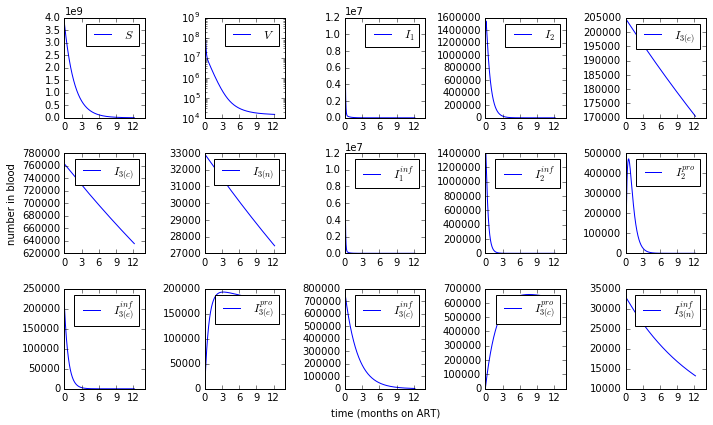

In [6]:
#look at all states

t   = np.linspace(0,365,1e5) #1 year time series in days
I1_t, I2_t, I3_t, Is_t, V_t, pct_obs, pct_dno, pct3_obs, sol = evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s)

state_names=['$S$','$V$','$I_1$','$I_2$','$I_{3(e)}$','$I_{3(c)}$','$I_{3(n)}$',
             '$I_1^{inf}$','$I_{2}^{inf}$','$I_{2}^{pro}$',
             '$I_{3(e)}^{inf}$','$I_{3(e)}^{pro}$',
             '$I_{3(c)}^{inf}$','$I_{3(c)}^{pro}$',
             '$I_{3(n)}^{inf}$','$I_{3(n)}^{pro}$']

S=S0*np.exp(-decay_s*t);          #susceptible cells
I1=sol[:,0]
V=n*(I1+pct_sanc*Is_0*np.exp(-decay_s*t))  #total virus

plt.figure(figsize=(10,6),dpi=rez)

plt.subplot(351)
plt.plot(t/30,S*5e6)
plt.legend([state_names[0]])
plt.xticks([0,3,6,9,12])

plt.subplot(352)
plt.semilogy(t/30,V*5e6)
plt.legend([state_names[1]])
plt.xticks([0,3,6,9,12])

for i in range(13):
    plt.subplot(3,5,i+3)
    plt.plot(t/30,sol[:,i]*5e6)
    plt.legend([state_names[i+2]])
    plt.xticks([0,3,6,9,12])
    if i==10:
        plt.xlabel('time (months on ART)')
    if i==3:
        plt.ylabel('number in blood')
plt.tight_layout()

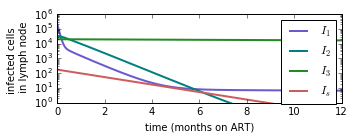

In [7]:
#simulating the model in 10mL lymph node (extra dense target cells also 10x)

t   = np.linspace(0,365,1e5) #1 year time series in days
sol = evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s)

plt.figure(figsize=(5,2),dpi=rez)
plt.semilogy(t/365*12,sol[0]*1e4*10,color='slateblue',lw=2)
plt.semilogy(t/365*12,sol[1]*1e4*10,color='teal',lw=2)
plt.semilogy(t/365*12,sol[2]*1e4*10,color='forestgreen',lw=2)
plt.semilogy(t/365*12,sol[3]*1e4*10,color='indianred',lw=2)
plt.ylim([1,1e6])
plt.xlabel('time (months on ART)')
plt.ylabel('infected cells \n in lymph node')

lgd=plt.legend(['$I_1$','$I_2$','$I_3$','$I_s$'])#titz,fontsize=12,bbox_to_anchor=(1.4, 1.05))

plt.tight_layout()
plt.savefig('figures/sim_LN.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')



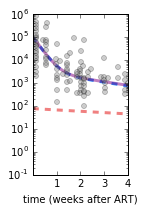

/Users/danielreeves/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


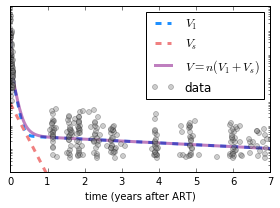

In [8]:
#plotting virus compared to sarah palmers data

dz1=pd.read_csv('data/Data_1-4weeks.csv',header=None,names=['t','vl'])     
dz2=pd.read_csv('data/Data_60-360weeks.csv',header=None,names=['t','vl'])
dz3=pd.read_csv('data/Data_60-360weeks_neg.csv',header=None,names=['t','vl'])

full_SP = pd.read_excel('data/edited_full_SP.xlsx')

#full_SP.head()

#early timepoints
t=np.linspace(0,4*7,1e3) #4 week time series in days
sol=evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s)

plt.figure(figsize=(2,2),dpi=rez)
plt.semilogy(t, sol[0]*n*1e3, '--',color='dodgerblue', lw=3) #V1
plt.semilogy(t, sol[3]*n*1e3, '--',color='lightcoral', lw=3) #Vs
plt.semilogy(t, sol[4], '-',color='purple', lw=3,alpha=0.5)  #V total
plt.semilogy(dz1.t*7,dz1.vl,'o',markersize=5,color='gray',alpha=0.4) #data
#plt.semilogy(full_SP['Day (DNE)'],full_SP['SCA Average Copies/mL'],'o',markersize=5,color='gray',alpha=0.4)
plt.ylim([0.1,1e6])
plt.xlim([0,28])
plt.xticks([7,14,21,28], [1,2,3,4])
plt.xlabel('viral load (copies/mL)')
plt.xlabel('time (weeks after ART)')
plt.tight_layout()
plt.savefig('figures/sim_blood_early.pdf')  # No warning now

#late timepoints
t=np.linspace(0,365*7,1e5) #7 year time series in days
sol=evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s)

plt.figure(figsize=(4,2),dpi=rez)
plt.semilogy(t, sol[0]*n*1e3, '--',color='dodgerblue', lw=3)
plt.semilogy(t, sol[3]*n*1e3, '--',color='lightcoral', lw=3)
plt.semilogy(t, sol[4], '-',color='purple', lw=3,alpha=0.5)
plt.semilogy(dz1.t*7,dz1.vl,'o',markersize=5,color='gray',alpha=0.4)
plt.semilogy(dz2.t*7,dz2.vl,'o',markersize=5,color='gray',alpha=0.4)
plt.semilogy(dz3.t*7,dz3.vl,'o',markersize=5,color='gray',alpha=0.4)
plt.xlim([0,7*365])
plt.ylim([0.1,1e6])
plt.xlabel('time (years after ART)')
plt.yticks([])
plt.legend([r'$V_1$',r'$V_s$',r'$V=n(V_1+V_s)$',r'data'], fontsize=12)
plt.xticks(np.arange(8)*365,np.arange(8))
plt.tight_layout()
plt.savefig('figures/sim_blood.pdf')  # No warning now



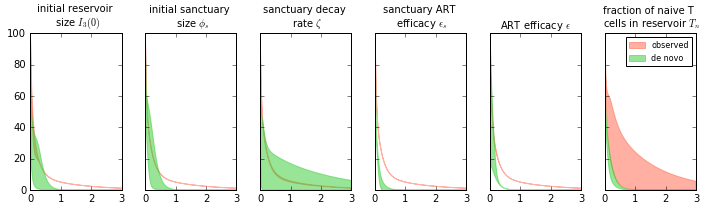

In [9]:

################################################################################
#local sensitivity analysis function

#variables to check sensitivity
variables = ['initial reservoir \n size ' + r'$I_3(0)$', 
             'initial sanctuary \n size ' + r'$\phi_s$',
             'sanctuary decay \n rate ' + r'$\zeta$', 
             'sanctuary ART \n efficacy ' + r'$\epsilon_s$',
             'ART efficacy ' + r'$\epsilon$', 
             'fraction of naive T \n cells in reservoir ' + r'$T_n$']

#ranges of variables for LHS
rangez= np.array([  
            [0.02,2],  #log latent reservoir concentration
            [0.1,10],        #log sanctuary cell fraction
            [0.002,0.2],        #log sanctuary decay rate [per day]
            [0,0.9],            #ART efficacy in sanctuary
            [0.90,0.99],        #ART efficacy elsewhere
            [0,0.5]])       #fraction naive
                            
t=np.linspace(0,3*365,1e3) #3 year time series in days

fig,axarr = plt.subplots(1,6,sharex=True,sharey=True,figsize=(10,3),dpi=rez)
#looping over the number of variables to check sensitivity
for i in range(len(variables)):

    #[  I3(0)  pct_sanc zeta  eps_s  eps   Tn (set the typicl values)
    lo=[0.2,   1,       0.02, 0,     0.95, 0.1];      
    hi=[0.2,   1,       0.02, 0,     0.95, 0.1]; 

    #change the i-th parameter
    lo[i]=rangez[i][0] 
    hi[i]=rangez[i][1]
    
    lo_pie=np.array([0.5-lo[5],0.5,lo[5]])
    hi_pie=np.array([0.5-hi[5],0.5,hi[5]])

    #evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc,decay_s)

    LO_sol = evaluate_model(t,I1_0,I2_0,lo[0],lo[4],lo[3],lo_pie,lo[1]*1e-5,lo[2])
    HI_sol = evaluate_model(t,I1_0,I2_0,hi[0],hi[4],hi[3],hi_pie,hi[1]*1e-5,hi[2])        

    #cumulative plots
    #ax=axarr[i%2][int(np.floor(i/2))]
    ax=axarr[i]
    #ax.semilogy(t/365,med[5],t,HI_sol[5],alpha=0.1,color='chocolate')
    ax.fill_between(t/365,LO_sol[5],HI_sol[5],alpha=0.5,color='tomato') #observed
    ax.fill_between(t/365,LO_sol[6],HI_sol[6],alpha=0.5,color='limegreen') #de novo

    ax.set_ylim([0.1,100])
    ax.set_title(variables[i],fontsize=10)# + str(rangez[i][0]) + r'$\to$' +str(rangez[i][1]),fontsize=10)
    ax.set_xticks(range(4))

#axarr[0][0].set_ylabel('percent of infected cells \n from ongoing replication',fontsize=10)
#axarr[1][0].set_ylabel('percent of infected cells \n from ongoing replication',fontsize=10)
#axarr[1][1].set_xlabel('time (years on ART)',fontsize=10)
ax.legend(['observed','de novo'],fontsize=8,loc=1)

plt.tight_layout()
plt.savefig('figures/sensitivity_local.pdf')




In [10]:
################################################################################
#global sensitivity analysis function
sampz=10**4

'''SHORT NAMES
variables=[ r'$I_3(0)$', 
            r'$\phi_s\cdot$', 
            r'$\zeta$',    
            r'$\epsilon_s$', 
            r'$\epsilon$', 
            r'$T_n$', 
            r'$k$'] #variables to check sensitivity
'''

lhs_samples = pyDOE.lhs( int(len(variables)), samples=sampz, criterion='center')

t=np.linspace(0,6*365,1e3) #6 year time series in days

var_vals=[]; cum_pct=[]; dno_pct=[]

fig3=plt.figure(figsize=(4,4),dpi=rez)

#looping over the number of LHS samples
for i in range(sampz):

    I3_0    = 10**(np.log10(rangez[0][0]) + 
                    lhs_samples[i][0]*(np.log10(rangez[0][1])-np.log10(rangez[0][0])))

    pct_sanc= 10**(np.log10(rangez[1][0]) + 
                    lhs_samples[i][1]*(np.log10(rangez[1][1])-np.log10(rangez[1][0])))

    decay_s = 10**(np.log10(rangez[2][0]) + 
                    lhs_samples[i][2]*(np.log10(rangez[2][1])-np.log10(rangez[2][0])))

    eps_s   = rangez[3][0] + lhs_samples[i][3]*(rangez[3][1]-rangez[3][0]) 
    eps     = rangez[4][0] + lhs_samples[i][4]*(rangez[4][1]-rangez[4][0]) 
    Tn      = rangez[5][0] + lhs_samples[i][5]*(rangez[5][1]-rangez[5][0]) 

    var_vals.append([I3_0,pct_sanc,decay_s,eps_s,eps,Tn])

    pie=np.array([0.5,1-Tn-0.5,Tn])        

    sol = evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,pct_sanc*1e-5,decay_s)

    #percentages at num_months months
    num_months=12;

    ind=int(round(num_months*30/(t[-1]/len(t))))

    #print('index for readout',ind)

    percentages=[sol[6],sol[5]]

    cum_pct.append(sol[5][ind]); dno_pct.append(sol[6][ind])

    #make 4 plots showing variation              
    cz=['limegreen','tomato']
    if sampz<100:
        for j in range(2):            
            plt.subplot(221+j)
            plt.plot(t,percentages[j],color=cz[j],alpha=0.3)
            plt.ylim([0,100])
            plt.xticks([0,365*2,365*4,6*365], [0,2,4,6])
            plt.tick_params(axis='both', which='major', labelsize=8)
            plt.xlabel('time (years on ART)',fontsize=8)
            if j==0:
                plt.ylabel('percent from \n ongoing replication (%)',fontsize=8)
                #plt.title('de novo',fontsize=8)
            #else:
                #plt.title('observed',fontsize=8)

            plt.subplot(223+j)
            plt.semilogy(t,percentages[j],color=cz[j],alpha=0.3)
            plt.xlim([0,t[170]])
            plt.ylim([0.1,100])
            plt.xticks([0,365*1/3,365*2/3,365], [0,4,8,12])
            plt.tick_params(axis='both', which='major', labelsize=8)
            if j==0:
                plt.ylabel('percent from \n ongoing replication (%)',fontsize=8)
            plt.xlabel('time (months on ART)',fontsize=8)

        #plt.legend(['Cumulative','de novo'],fontsize=8)
        plt.gcf().set_tight_layout(True)
        plt.gcf().savefig('sensitivity_examples.pdf')



/Users/danielreeves/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


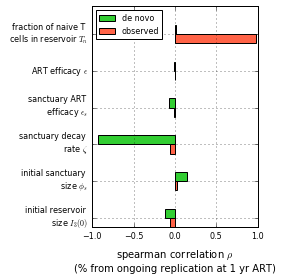

In [11]:

var_vals=np.asarray(var_vals)

PR_cum=[]; PR_dno=[]

#correlation scatter plots (commented out for now)

#fig4=plt.figure(figsize=(8,4),dpi=rez) #plot each correlation
for k in range(len(variables)):

    PR_cum.append(spearmanr(var_vals[:,k],cum_pct))
    PR_dno.append(spearmanr(var_vals[:,k],dno_pct))

    '''
    plt.subplot(241+k)
    plt.scatter(var_vals[:,k],dno_pct,color='green')
    plt.scatter(var_vals[:,k],cum_pct,color='limegreen')
    #if log10(rangez[k,1]-rangez[k,0])>1:
    #    plt.xaxis('log')
    if k==0 or k==4:
        plt.ylabel('Infection (%)')

    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.yticks([25,50,75,100])
    plt.ylim([0,110])
    plt.xlim([rangez[k,0],rangez[k,1]])
    plt.xticks([rangez[k,0],rangez[k,0]+(rangez[k,1]-rangez[k,0])/2,rangez[k,1]])
    plt.xlabel(variables[k],fontsize=8)
    #plt.gca().ticklabel_format(axis='x', style='sci',labelsize=8)

plt.legend(['Observed','de novo'],fontsize=8)
plt.gcf().set_tight_layout(True)
plt.gcf().savefig('sensitivity_scatterplots.pdf')
'''
cum_corrs=np.asarray(PR_cum); dno_corrs=np.asarray(PR_dno)

#correlation coefficient bar plots
fig5=plt.figure(figsize=(4,4),dpi=rez)
bspace=np.arange(0,len(variables)*2,2)

#sort the variable names for y axis labels
#indz=cum_corrs[:,0].argsort()
#sorted_vars=[]
#for kk in range(len(variables)):
#    sorted_vars.append(variables[indz[kk]])

plt.barh(bspace+0.5,dno_corrs[:,0],0.5,color='limegreen')
plt.barh(bspace,cum_corrs[:,0],0.5,color='tomato')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(np.linspace(-1,1,5))
plt.xlabel('spearman correlation '+ r'$\rho$' + '\n(% from ongoing replication at 1 yr ART)',fontsize=10)
plt.grid('on')
plt.yticks(bspace+0.5,variables,fontsize=8)
plt.legend(['de novo','observed'],fontsize=8,loc=2)

plt.gcf().set_tight_layout(True)
plt.gcf().savefig('figures/sensitivity_correlationcoeffs.pdf')
    


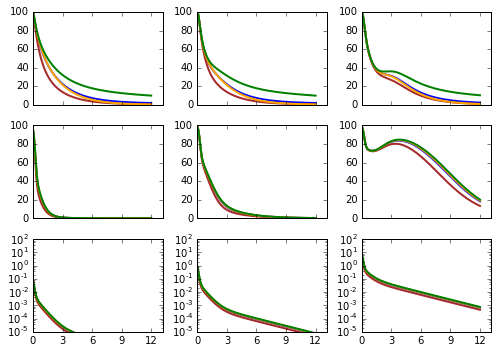

In [12]:
################################################################################
#plotting function for percentages

t   = np.linspace(0,365,1e3) #3 year time series in days

cz=['blue','brown','orange','green']
lwz=2 

#fig7=plt.figure(figsize=(5,4),dpi=rez)

reservoir=[[10.0/5,0.1],[1./5,1],[0.1/5,10]] #low medium and high worst case scenarios

fig,axarr = plt.subplots(3,3,sharex=True,sharey=False,figsize=(7,5),dpi=rez)

for j in range(3):
    for i in range(4):
        pie=list_pie[i]/sum(list_pie[i])

        I3_0=reservoir[j][0]
        Is_0=reservoir[j][1]*1e-5
        
        sol=evaluate_model(t,I1_0,I2_0,I3_0,eps,eps_s,pie,Is_0,decay_s)

        ax1=axarr[0][j]
        ax2=axarr[1][j]
        ax3=axarr[2][j]

        ax2.plot(t, sol[6], color=cz[i],lw=lwz) #de novo
        ax2.set_ylim([0,100])

        ax3.semilogy(t, sol[7], color=cz[i],lw=lwz) #de novo
        ax3.set_ylim([1e-5,105])

        ax1.plot(t, sol[5], color=cz[i],lw=lwz) #cumulative
        ax1.set_ylim([0,100])

#plt.yticks(np.linspace(0,100,5),[0,25,50,75,100])
plt.xticks(np.linspace(0,365,5),[0,3,6,9,12])

plt.tight_layout()
plt.savefig('figures/variations_pies_sizes.pdf')



